In [7]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc


dir_name = 'C:\\Users\\klipk\\Downloads\\'
zip_path = dir_name + 'eighty_five_cool.zip'         # Path to your ZIP file
# file_inside_zip = 'document.txt' # File you want to read from inside the ZIP
from read_teensy_binary import get_teensy_binary_data
import zipfile
from matplotlib import pyplot as plt

file_inside_zip = 'eighty_five_cool68.bin'
vals = []
M_times = []
M_voltages = []
M_temperatures = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:  # use 'r', not 'rb'
    for i in range(67, 270):
        file_inside_zip = f'eighty_five_cool{i+1:d}.bin'
        with zip_ref.open(file_inside_zip) as f:
            times, voltages, T_therm = get_teensy_binary_data(f)
            M_times.append([times])
            M_voltages.append([voltages])
            M_temperatures.append(np.average(T_therm))
M_times = np.array(M_times)
M_voltages = np.array(M_voltages)
M_temperatures = np.array(M_temperatures)
results = []
last_T = -1000
cnt = 0
Vmean = 0.0
Tmean = 0.0
tmean = 0.0

for t, V, T in zip(M_times, M_voltages, M_temperatures):
    if np.abs(last_T - T) > 5:
        if last_T != -1000 and cnt > 0:
            # Save previous group
            results.append((tmean / cnt, Vmean / cnt, Tmean / cnt))
        # Start new group
        cnt = 1
        Vmean = V
        tmean = t
        Tmean = T
        last_T = T
    else:
        cnt += 1
        Vmean += V
        tmean += t
        Tmean += T

# Catch final group
if cnt > 0:
    results.append((tmean / cnt, Vmean / cnt, Tmean / cnt))

import json

# Construct JSON-safe structure
data_to_save = {
    "metadata": {
        "source_zip": zip_path,
        "binning_delta_T": 5,
        "original_file_count": len(M_temperatures)
    },
    "datasets": {}
}

# Build the dataset entries
for idx, (tmean, Vmean, Tmean) in enumerate(results):
    dataset_name = f"dataset_{idx}"
    data_to_save["datasets"][dataset_name] = {
        "temperature": float(Tmean),  # ensure it's JSON-serializable
        "x": tmean[0].tolist(),       # flatten single-element array and convert to list
        "y": Vmean[0].tolist()
    }

# Save to JSON file
with open("merged_data_1deg.json", "w") as f:
    json.dump(data_to_save, f, indent=2)
# ----------------------------


(0.001, 1.2)

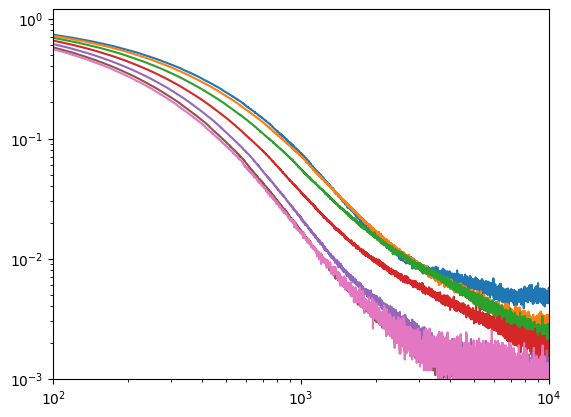

: 

In [ ]:
# ✅ Plotting Block (outside loop)
# ----------------------------
for tgg, Vgg, Tgg in results:
    if Tgg < -30:
        plt.plot(tgg[0], Vgg[0]/Vgg[0][0], label=f'Tgg = {Tgg:3.1f}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,1e4)
plt.ylim(1e-3,1.2)